In [452]:
# %reset

In [453]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


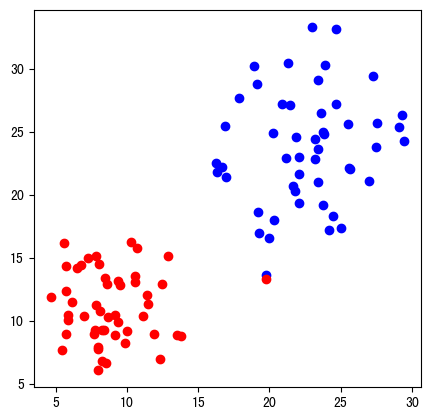

In [454]:
# 获取数据集（具有正态分布的）
x_1_1 = pd.Series(np.random.normal(loc=22, scale=4, size=50), name='x1')
x_1_2 = pd.Series(np.random.normal(loc=24, scale=4, size=50), name='x2')
y_1 = pd.Series(['blue'] * 50, name='target')

x_2_1 = pd.Series(np.random.normal(loc=8, scale=3, size=50), name='x1')
x_2_2 = pd.Series(np.random.normal(loc=12, scale=3, size=50), name='x2')
y_2 = pd.Series(['red'] * 50, name='target')

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(x_1_1, x_1_2, c='blue')
plt.scatter(x_2_1, x_2_2, c='red')
plt.show()

tmp_data_1 = pd.concat([x_1_1, x_1_2, y_1], axis=1)
tmp_data_2 = pd.concat([x_2_1, x_2_2, y_2], axis=1)
data = pd.concat([tmp_data_1, tmp_data_2], axis=0)
data = shuffle(data).reset_index(drop=True)  # 打乱样本顺序

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1])

# 归一化
transfer = MinMaxScaler(feature_range=(0, 10))
x_train = transfer.fit_transform(X=x_train)
x_test = transfer.transform(X=x_test)


# CUC 的主类

In [455]:
# ------*------ coding: utf-8 ------*------
# @Time    : 2023/3/27 18:45
# @Author  : 冰糖雪狸 (NekoSilverfox)
# @Project : CUC
# @File    : CodingUnitClassifier.py
# @Software: PyCharm
# @Github  ：https://github.com/NekoSilverFox
# -----------------------------------------
class CodingUnitClassifier(object):
    """编码单元分类器预估器（estimator）"""

    def __init__(self, num_continuing_splits=0, threshold_value=1.0, is_draw_2D=False, **kw) -> None:
        """初始化

        Args:
            num_continuing_splits (int, optional): 细化分割次数. Defaults to 0.
            threshold_value (int, optional): 临界值. Defaults to  1.0.
            is_draw_2D (bool, optional): 当绘制 2D 数据集，是否绘制中途图像. Defaults to False.
        """
        self.split_count = 0  # 分割次数计数器
        self.is_draw_2D = is_draw_2D
        self.num_continuing_splits = num_continuing_splits
        self.threshold_value = threshold_value  # 临界值：当某个 CU 中某种粒子占比超过这个阈值，则暂停分割

        self.transfer_LabelEncoder = None  # 目标值的转换器（转为数字）

        self.N_train = None  # 训练集的维度
        self.X_train = None  # 特征值（训练集）
        self.y_train = None  # 目标值（训练集）
        self.df_train = None  # 以 pandas.DataFream 形式的训练接数据（特征值和训练集是合并在一起的）。目标值的索引为 `target`，特征值的索引为 `x`，x 为从 0 开始的数字

        self.CU_min = None  # 编码单元范围最小值
        self.CU_max = None  # 编码单元范围最小值

        self.arr_CU_start_points = None  # 编码单元起始点列表
        self.arr_CU_dL = None  # arr_CU_start_points 对应位置的编码单元的边长 `dL`
        self.arr_CU_is_enable = None  # arr_CU_start_points 对应位置的编码单元是否启用，True 代表启用，False 代表不启用
        self.arr_CU_splits_count = None  # arr_CU_start_points 对应位置的编码单元是通过几次分割所得到的
        self.arr_CU_final_target = None  # arr_CU_start_points 对应位置的编码单元的最终预测类别（-1 代表无类别）
        self.arr_CU_force_infection = None  # arr_CU_start_points 对应位置的编码单元的感染力度 (force of infection)

    def is_CU_need_split(self, arr1d_start_points: np.ndarray, dL: np.float) -> np.int:
        """判断当前 CU 是否需要继续预分割（如果需要返回 -1，如果不需要返回当前 CU 所属的目标值，并且 -2 代表为空白 CU）

        Args:
            arr1d_start_points (np.ndarray): 当前 CU 的起始点
            dL (np.float): 当前 CU 的边长

        Raises:
            ValueError: _description_
            ValueError: _description_

        Returns:
            _type_: True为需要进一步分割，如果不需要返回当前 CU 所属的目标值
        """
        if dL <= 0:
            raise ValueError(f'[CUC-ERROR] dl can not <= 0, your dL is {dL}')
        if arr1d_start_points.shape[0] != self.N_train:
            raise ValueError(
                f'[CUC-ERROR] arr1d_start_points.shape not correct: arr1d_start_points.shape is {arr1d_start_points.shape}, '
                f'should be ({self.N_train}, )')

        CU_end_points = np.array(arr1d_start_points + dL)  # 结束点
        s_type_count = pd.Series(index=np.unique(self.y_train)).fillna(value=0)  # 计数器，列索引为类别，对应位置数据为该 CU 中此种类粒子数量

        # 遍历判断点是否在这个 CU  中
        for col, col_target in zip(self.X_train, self.y_train):  # col_target 为当前行的目标值
            # 判断粒子在此维度上是否介于 CU 的起始点和结束点
            if (col > arr1d_start_points).all() & (col < CU_end_points).all():
                s_type_count[col_target] += 1

        # -1 代表这个编码单元里没有任何粒子，为空白编码单元
        if -2 == s_type_count.sum():
            return -2

        s_type_count = s_type_count / s_type_count.sum()  # 转换为概率
        if (s_type_count.max() >= self.threshold_value) & (
                1 == s_type_count[s_type_count.values == s_type_count.max()].shape[0]):  # 不允许出现两种相同概率
            return s_type_count[s_type_count.values == s_type_count.max()].index[0]
        else:
            return -1

    def split_CU_and_update2arrCU(self, index_start_points: int) -> None:
        """分割当前 CU，并将分割的结果更新到方法内部成员

        Args:
            index_start_points (int): 需要分割 CU 的索引
        """
        if self.arr_CU_is_enable[index_start_points] is False:
            raise ValueError(f'[CUC-ERROR] CU on index {index_start_points} already disable, can not continue split')

        self.arr_CU_is_enable[index_start_points] = False  # 既然对这个单元分割就说明这个单元不再使用了，因为它被差分成了许多新的小单元

        start_points = self.arr_CU_start_points[index_start_points, :]
        new_dL = self.arr_CU_dL[index_start_points] / 2
        end_points = np.array(start_points + new_dL)

        # 生成包含所有可能性组合的列表
        combinations = []
        for i in range(2 ** self.N_train):
            new_combination = []
            for j in range(self.N_train):
                if i & (1 << j):
                    new_combination.append(end_points[j])
                else:
                    new_combination.append(start_points[j])
            combinations.append(new_combination)

        print(f'[INFO] -------------split-------------\n'
              f'new_dL: {new_dL}\n'
              f'new_combination:\n{combinations}')

        # 分割后的 CU 添加至缓冲区
        self.arr_CU_start_points = np.vstack([self.arr_CU_start_points, np.array(combinations)])
        self.arr_CU_dL = np.hstack([self.arr_CU_dL, np.full(shape=(2 ** self.N_train,), fill_value=new_dL)])
        self.arr_CU_is_enable = np.hstack([self.arr_CU_is_enable, np.full(shape=(2 ** self.N_train,), fill_value=True)])
        self.arr_CU_splits_count = np.hstack([self.arr_CU_splits_count, np.full(shape=(2 ** self.N_train,),
                                                                                fill_value=self.arr_CU_splits_count[index_start_points] + 1)])
        self.arr_CU_final_target = np.hstack(
            [self.arr_CU_final_target, np.full(shape=(2 ** self.N_train,), fill_value=-1, dtype=np.int)])

        self.split_count += 1

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """编码单元分类器的估计器（estimator）

        Args:
            X (np.ndarray): 特征值
            y (np.ndarray): 目标值

        Raises:
            ValueError: _description_
        """
        # 如果特征值和目标值维度相等
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'[CUC-ERROR] X.shape != y.shape: X.shape is {X.shape[0]}, y.shape is {y.shape[0]}')

        # 初始化 CUC 配置参数
        self.N_train = X.shape[1]
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.df_train = pd.concat([pd.DataFrame(self.X_train), pd.Series((self.y_train), name='target')], axis=1)

        self.CU_min = X.min()
        self.CU_max = X.max()

        # 目标值转为数值类型
        self.transfer_LabelEncoder = LabelEncoder()
        self.y_train = np.array(self.transfer_LabelEncoder.fit_transform(y=y), dtype=np.int)

        # 初始化 CU 相关 ndarray
        self.arr_CU_start_points = np.full(shape=(1, self.N_train), fill_value=self.CU_min)  # 将初始化中的 0.0 替换为编码单元的起始点
        self.arr_CU_dL = np.array([self.CU_max - self.CU_min])
        self.arr_CU_is_enable = np.array([True])
        self.arr_CU_splits_count = np.array([0])
        self.arr_CU_final_target = np.array([-1], dtype=np.int)
        self.arr_CU_force_infection = np.array([np.nan])

        # 预分割阶段
        current_index = 0
        while current_index < self.arr_CU_start_points.shape[0]:
            # 如果当前 CU 已经废弃（disable），那么就没有再对他进行处理的意义了
            if self.arr_CU_is_enable[current_index] is False:
                current_index += 1
                continue

            # 如果当前 CU 启用，但是已经有了最终类别
            if self.arr_CU_is_enable[current_index] is True and self.arr_CU_final_target[current_index] != -1:
                current_index += 1
                continue

            type_split = self.is_CU_need_split(arr1d_start_points=self.arr_CU_start_points[current_index, :],
                                               dL=self.arr_CU_dL[current_index])
            print(f'[INFO] CUC.fit(): current_index: {current_index} \t type_split: {type_split}')

            if type_split == -1:
                self.split_CU_and_update2arrCU(index_start_points=current_index)
            else:
                self.arr_CU_final_target[current_index] = type_split

            current_index += 1


In [487]:
estimator = CodingUnitClassifier()
# estimator.fit(X=x_train, y=y_train)

In [457]:
estimator.arr_CU_start_points

array([[0., 0.],
       [0., 0.],
       [5., 0.],
       [0., 5.],
       [5., 5.]])

绘制 CU

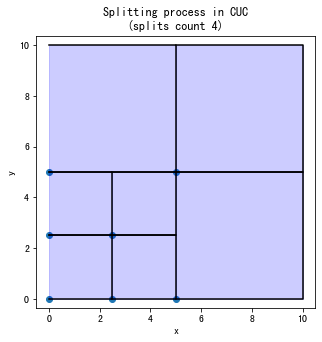

In [485]:
# 第一为：CU起始点的x
# 第二为：CU起始点的y
# 第三为：CU 的边长
data = np.array([
    [0,   0,   2.5],
    [2.5, 0,   2.5],
    [0,   2.5, 2.5],
    [2.5, 2.5, 2.5],
    [0,   5,   5],
    [5,   0,   5],
    [5,   5,   5]])

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1])
# plt.show()

num = 4

# plt.figure()
for i in data:
    t_x_block = [i[0], i[0]+i[2], i[0]+i[2], i[0]]
    t_y_block = [i[1], i[1],      i[1]+i[2], i[1]+i[2]]
    plt.plot(t_x_block, t_y_block, c='black')
    plt.fill(t_x_block, t_y_block, c='b', alpha=0.2)
    plt.title(f'Splitting process in CUC\n(splits count {num})')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.axis('equal')  # x、y 单位长度等长
    
plt.show()

In [459]:
def generate_combinations(arr1, arr2):
    # 获取数组长度
    n = len(arr1)
    # 生成包含所有可能性组合的列表
    combinations = []
    for i in range(2**n):
        new_combination = []
        for j in range(n):
            if i & (1<<j):
                new_combination.append(arr2[j])
            else:
                new_combination.append(arr1[j])
        combinations.append(new_combination)
    return combinations


In [460]:
generate_combinations(["0", "0"], ["1", "1"])

[['0', '0'], ['1', '0'], ['0', '1'], ['1', '1']]

In [467]:
estimator.X_train

array([[ 5.97069254,  2.77846819],
       [ 9.85924584,  7.14188368],
       [ 1.69133016,  2.49185283],
       [ 8.4403485 ,  5.89807742],
       [ 5.75695313,  4.02317876],
       [ 1.84049522,  0.79705646],
       [ 1.16425176,  0.27215699],
       [ 7.58243628,  7.52683851],
       [10.        ,  6.71917655],
       [ 0.56340964,  3.07673466],
       [ 7.69567883,  8.950001  ],
       [ 6.84730783,  6.84690366],
       [ 4.49841823,  6.06206039],
       [ 6.21790165,  4.39085998],
       [ 8.03034547, 10.        ],
       [ 1.36012815,  1.56643005],
       [ 6.93558733,  4.88715789],
       [ 4.5361889 ,  5.80441572],
       [ 7.65492373,  4.84491679],
       [ 1.16699015,  1.16674304],
       [ 6.62623876,  9.00792972],
       [ 2.5065654 ,  1.95110604],
       [ 1.65018362,  2.61844238],
       [ 6.44552358,  7.79733703],
       [ 5.72358414,  8.37844743],
       [ 2.68446827,  1.04906083],
       [ 1.56648799,  1.62529889],
       [ 8.36205256,  7.22701919],
       [ 7.49524583,

In [462]:
estimator.y_train.T.shape

(75,)

In [472]:
pd.Series(estimator.y_train)

0     0
1     0
2     1
3     0
4     0
     ..
70    0
71    0
72    1
73    0
74    0
Length: 75, dtype: int64

In [481]:
tmp_data = pd.concat([pd.DataFrame(estimator.X_train), pd.Series(estimator.y_train)], axis=1)
tmp_data.columns=('x', 'y', 'target')
tmp_data[tmp_data['target'] == 0].values[:, :-1]

array([[ 5.97069254,  2.77846819],
       [ 9.85924584,  7.14188368],
       [ 8.4403485 ,  5.89807742],
       [ 5.75695313,  4.02317876],
       [ 7.58243628,  7.52683851],
       [10.        ,  6.71917655],
       [ 7.69567883,  8.950001  ],
       [ 6.84730783,  6.84690366],
       [ 4.49841823,  6.06206039],
       [ 6.21790165,  4.39085998],
       [ 8.03034547, 10.        ],
       [ 6.93558733,  4.88715789],
       [ 4.5361889 ,  5.80441572],
       [ 7.65492373,  4.84491679],
       [ 6.62623876,  9.00792972],
       [ 6.44552358,  7.79733703],
       [ 5.72358414,  8.37844743],
       [ 8.36205256,  7.22701919],
       [ 7.49524583,  8.52037372],
       [ 5.17212891,  7.96660177],
       [ 7.50096583,  6.47967837],
       [ 9.94346097,  7.49351938],
       [ 8.17613947,  4.17516679],
       [ 6.95218527,  5.75756606],
       [ 4.69257182,  5.95608207],
       [ 9.21799374,  7.23614556],
       [ 8.39617834,  5.94150459],
       [ 5.7451061 ,  4.6356066 ],
       [ 7.92358922,

In [486]:
estimator.N_train

2